# Understanding Washington State Cannabis Sale Forecasts

## Introduction

In November 2012, Washington State voters approved to legalize marijuana through [Washington Initiative 502 (I-502)](https://sos.wa.gov/_assets/elections/initiatives/i502.pdf) by a margin of approximately [56 to 44](https://results.vote.wa.gov/results/20121106/Initiative-Measure-No-502-Concerns-marijuana_ByCounty.html). As part of this initiative, Washington State created a new agency, the [Washington State Liquor and Cannabis Board (WSLCB)](https://lcb.wa.gov), for licensing and regulating liquor and marijuana. As part of its mandate the WSLCB provides public access to [data](https://data.lcb.wa.gov) on how Washington States’s marijuana market is performing.

In this exercise, we will analyze daily sales data from 2015-11-01 to 2017-03-04 in an attempt to answer the following questions:

1. How many previous weeks influence cannabis sales?
1. What days exhibit unusual sales?
1. Do stores in counties that voted to legalize marijuana behave differently that those that didn't?

## Setup

This analysis will use H2O's Sparkling Water to analyze cannabis sales data, where Spark will be used for data management and manipulation and H2O will be use for data analysis and python will be used as the client. This Jupyter notebook assumes that it was launched with a PySparkling context.

### Create H2O Context inside Spark Cluster

When using PySparkling, the first step is to create a Sparkling Water context within the Spark context, `spark`, so data can be passed back and forth between Spark and H2O.

In [1]:
from pysparkling import *
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.17.0.2:54321... successful.


H2O cluster uptime:,08 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,13 days
H2O cluster name:,sparkling-water-h2o_local-1534208179743
H2O cluster total nodes:,1
H2O cluster free memory:,7.052 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * H2O name: sparkling-water-h2o_local-1534208179743
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,d59dd40eeeda,54321)
  ------------------------

  Open H2O Flow in browser: http://172.17.0.2:54321 (CMD + click in Mac OSX)

    


## Data Preparation using Spark

The next step is to use Spark to prepare the data for analysis by H2O. The particular data manipulations are:

1. Read daily sales transactions
1. Create daily sales aggregates by store
1. Find unusual days
1. Join county voting results for I-502 with aggregated data
1. Collapse infrequent counties and cities for analysis, i.e. manage high cardinality categorical columsn
1. Create lagged predictors
1. Create train / test splits for modeling

### Read Daily Sales Transactions for Different Stores

Reading the data involve a straight-forward use of the `spark.read.csv` function with the schema metadata. The data file contains six columns:

|     | Column Name | Description |
| --- | ----------- | ----------- |
|  1  | SalesDate | Date of sale|
|  2  | Organization | Organization that owns the store |
|  3  | County | County of store location|
|  4  | City | City of store location |
|  5  | Sales Price | Price of line item |
|  6  | Freq | Number of occurrences |

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
schema = StructType([StructField('SalesDate', DateType(), metadata = {'desc': 'Date of sale'}),
                     StructField('Organization', StringType(), metadata = {'desc': 'Organization that owns the store'}),
                     StructField('County', StringType(), metadata = {'desc': 'County of store location'}),
                     StructField('City', StringType(), metadata = {'desc': 'City of store location'}),
                     StructField('SalesPrice', DoubleType(), metadata = {'desc': 'Price of line item'}),
                     StructField('Freq', IntegerType(), metadata = {'desc': 'Number of occurrences'})
                    ])

# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/time_series/wa_cannabis/WA_Cannabis_Sales_Daily.csv
raw_sales = spark.read.csv('../../data/topics/time_series/wa_cannabis/WA_Cannabis_Sales_Daily.csv',
                           header = True, schema = schema)

In [4]:
# Describe numeric and string columns
raw_sales.describe().show()

+-------+-------------+-------+--------+-----------------+------------------+
|summary| Organization| County|    City|       SalesPrice|              Freq|
+-------+-------------+-------+--------+-----------------+------------------+
|  count|      3765407|3765407| 3765407|          3765407|           3765407|
|   mean|         null|   null|    null|26.74136408893552|  8.11807701000184|
| stddev|         null|   null|    null| 35.7532082540557|20.264077828026984|
|    min|     #HASHTAG|  ADAMS|ABERDEEN|          -651.78|                 1|
|    max|WORLD OF WEED| YAKIMA|    YELM|          3104.92|              2175|
+-------+-------------+-------+--------+-----------------+------------------+



In [5]:
# Additional summaries
raw_sales.select([count('*').alias('nrows'), min('SalesDate'), max('SalesDate'), countDistinct('Organization')]).show()

+-------+--------------+--------------+----------------------------+
|  nrows|min(SalesDate)|max(SalesDate)|count(DISTINCT Organization)|
+-------+--------------+--------------+----------------------------+
|3765407|    2015-11-01|    2017-03-04|                         222|
+-------+--------------+--------------+----------------------------+



### Create Daily Sales Aggregates by Store

In order to analyze aggreate sales demand, the transactional sales data are aggregated three ways, each of which uses the `log(x + 1)` function to manage their inherent skewness:

1. `Log1pDemandInThou = log1p(sum(store sales)/1000)`
1. `Log1pOtherDemandInThou = log1p(sum(citywise sales)/1000) - log1p(sum(store sales)/1000)`, demand from the rest of the organizations
1. `Log1pNumSales = log1p(sum(I(store sales > 0)))`

In [6]:
demand = raw_sales.groupBy('SalesDate', 'Organization', 'County', 'City') \
    .agg(log1p(sum(col('Freq') * col('SalesPrice')) / 1000).alias('Log1pDemandInThou'),
         log1p(sum(when(col('SalesPrice') > 0, col('Freq')).otherwise(0))).alias('Log1pNumSales')) \
    .alias('demand')
print("Number of Organization-Days: ", demand.count())

('Number of Organization-Days: ', 87279)


In [7]:
demand.describe().show()

+-------+-------------+------+--------+--------------------+------------------+
|summary| Organization|County|    City|   Log1pDemandInThou|     Log1pNumSales|
+-------+-------------+------+--------+--------------------+------------------+
|  count|        87279| 87279|   87279|               87278|             87279|
|   mean|         null|  null|    null|  1.5845741187313314|  5.43356257230457|
| stddev|         null|  null|    null|  0.7088442952488704|1.0017507127933845|
|    min|     #HASHTAG| ADAMS|ABERDEEN|-0.02223538405071...|               0.0|
|    max|WORLD OF WEED|YAKIMA|    YELM|  3.9183588912456506| 8.152774052744075|
+-------+-------------+------+--------+--------------------+------------------+



In [8]:
daily_demand = raw_sales.groupBy('SalesDate') \
    .agg(log1p(sum(col('Freq') * col('SalesPrice')) / 1000).alias('Log1pCitywideDemandInThou')) \
    .alias('daily_demand')
print("Number of Days: ", daily_demand.count())

('Number of Days: ', 490)


In [9]:
demand = demand.join(daily_demand, demand.SalesDate == daily_demand.SalesDate, how = "left_outer") \
    .select('demand.*', 'daily_demand.Log1pCitywideDemandInThou')
print("Number of Organization-Days: ", demand.count())

('Number of Organization-Days: ', 87279)


In [10]:
demand = demand.select('SalesDate', 'Organization', 'County', 'City', 'Log1pDemandInThou',
                       (col('Log1pCitywideDemandInThou') - col('Log1pDemandInThou')).alias('Log1pOtherDemandInThou'),
                       'Log1pNumSales') \
         .alias('demand')

In [11]:
demand.describe(['Log1pDemandInThou', 'Log1pOtherDemandInThou', 'Log1pNumSales']).show()

+-------+--------------------+----------------------+-----------------+
|summary|   Log1pDemandInThou|Log1pOtherDemandInThou|    Log1pNumSales|
+-------+--------------------+----------------------+-----------------+
|  count|               87278|                 87278|            87279|
|   mean|  1.5845741187313314|    5.2779171104516465|5.433562572304564|
| stddev|  0.7088442952488708|    0.7240699016354217|1.001750712793385|
|    min|-0.02223538405071...|     2.646763824081182|              0.0|
|    max|  3.9183588912456506|     7.300001605928917|8.152774052744075|
+-------+--------------------+----------------------+-----------------+



### Find Unusual Days

Fifteen unusual days are discovered by examining the week-over-week ratios in `Log1pCitywideDemandInThou`. Not surprisingly, these days are at or around [420](https://en.wikipedia.org/wiki/420_%28cannabis_culture%29) and the holidays Fourth of July, Thanksgiving, Christmas, and New Year's.

In [12]:
from pyspark.sql.window import Window

w = Window().orderBy(col('SalesDate'))
plot_data = \
  daily_demand.select('SalesDate', 'Log1pCitywideDemandInThou',
                      round(col('Log1pCitywideDemandInThou') / lag('Log1pCitywideDemandInThou', count = 7).over(w), 4).alias('WoW'),
                      round(abs(col('Log1pCitywideDemandInThou') / lag('Log1pCitywideDemandInThou', count = 7).over(w) - 1), 4).alias('AbsWoWDiff')) \
                      .orderBy('AbsWoWDiff', ascending = False).toPandas()

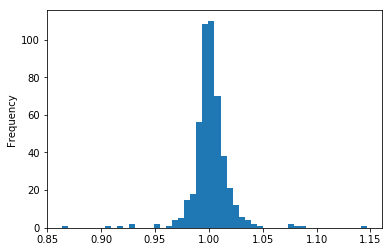

In [13]:
%matplotlib inline
plot_data['WoW'].plot.hist(bins = 50)

In [14]:
plot_data.head(20)

,SalesDate,Log1pCitywideDemandInThou,WoW,AbsWoWDiff
0,2016-01-01,6.584401,1.1465,0.1465
1,2015-12-25,5.742801,0.8641,0.1359
2,2016-12-25,6.332216,0.9057,0.0943
3,2016-04-20,7.177266,1.0871,0.0871
4,2015-12-24,6.973423,1.0812,0.0812
5,2016-04-27,6.602294,0.9199,0.0801
6,2017-01-01,6.829579,1.0785,0.0785
7,2015-11-25,6.725603,1.0734,0.0734
8,2016-01-07,6.463089,0.9276,0.0724
9,2015-12-26,6.328705,0.9305,0.0695


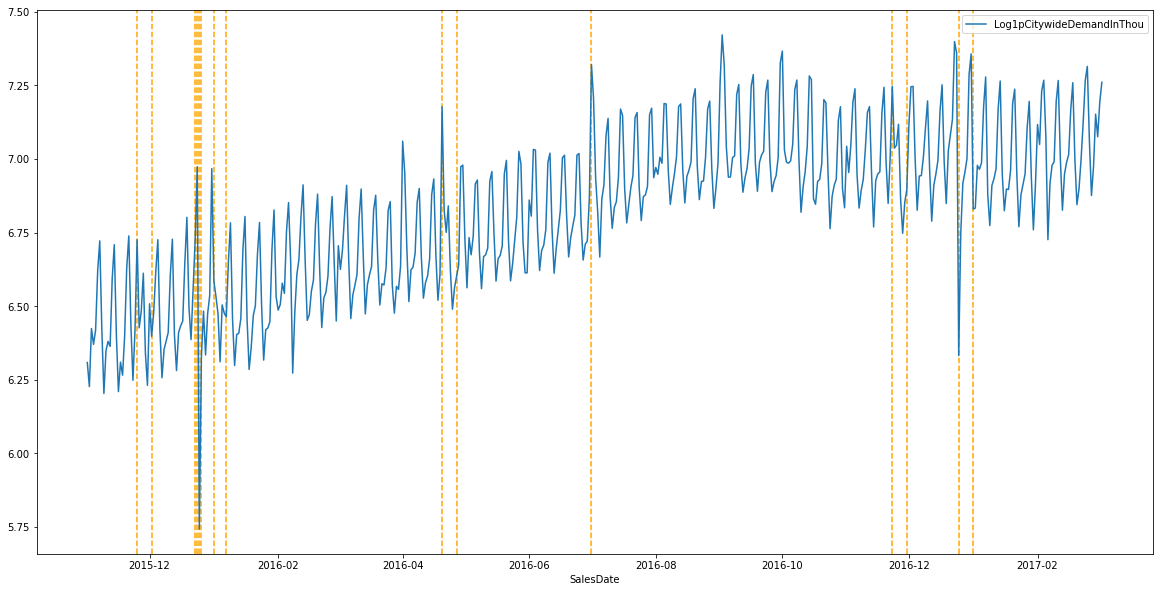

In [15]:
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20, 10))
for dt in ['2015-11-25', '2015-12-02', '2015-12-23', '2015-12-24', '2015-12-25', '2015-12-26', '2016-01-01',
           '2016-01-07', '2016-04-20', '2016-04-27', '2016-07-01',
           '2016-11-23', '2016-11-30',                             '2016-12-25',               '2017-01-01']:
    plt.axvline(x = datetime.datetime.strptime(dt, '%Y-%m-%d'), color = 'orange', linestyle='--')
plot_data.plot(x = 'SalesDate', y = 'Log1pCitywideDemandInThou', ax = ax)
plt.show()

In [16]:
demand = demand.select('*',
                       when(col('SalesDate') == '2016-04-20', 'FourTwenty')
            .otherwise(when(col('SalesDate') == '2016-04-27', 'FourTwentySeven')
            .otherwise(when(col('SalesDate') == '2016-07-01', 'PreJuly4th')
            .otherwise(when(col('SalesDate') == '2015-11-25', 'ThanksgivingMinusOne')
            .otherwise(when(col('SalesDate') == '2016-11-23', 'ThanksgivingMinusOne')
            .otherwise(when(col('SalesDate') == '2015-12-02', 'ThanksgivingPlusSix')
            .otherwise(when(col('SalesDate') == '2016-11-30', 'ThanksgivingPlusSix')
            .otherwise(when(col('SalesDate') == '2015-12-23', 'ChristmasMinusTwo')
            .otherwise(when(col('SalesDate') == '2015-12-24', 'ChristmasMinusOne')
            .otherwise(when(col('SalesDate') == '2015-12-25', 'Christmas')
            .otherwise(when(col('SalesDate') == '2016-12-25', 'Christmas')
            .otherwise(when(col('SalesDate') == '2015-12-26', 'ChristmasPlusOne')
            .otherwise(when(col('SalesDate') == '2016-01-01', 'NewYearsDay')
            .otherwise(when(col('SalesDate') == '2017-01-01', 'NewYearsDay')
            .otherwise(when(col('SalesDate') == '2016-01-07', 'NewYearsDayPlusSix')
            .otherwise('N/A'))))))))))))))).alias('DayOfInterest')).alias('demand')

In [17]:
demand.groupBy('DayOfInterest').count().sort('count', ascending = False).show()

+--------------------+-----+
|       DayOfInterest|count|
+--------------------+-----+
|                 N/A|84886|
|         NewYearsDay|  347|
| ThanksgivingPlusSix|  345|
|ThanksgivingMinusOne|  344|
|           Christmas|  306|
|          PreJuly4th|  185|
|     FourTwentySeven|  170|
|          FourTwenty|  165|
|  NewYearsDayPlusSix|  136|
|   ChristmasMinusTwo|  133|
|   ChristmasMinusOne|  133|
|    ChristmasPlusOne|  129|
+--------------------+-----+



### Join Sales Data with Washington Initiative 502 Vote to Legalize Cannabis

Generally speaking counties in Western Washington voted to legalize cannabis sales, while those in Eastern Washington did not.

In [18]:
schema = StructType([StructField('County', StringType(), metadata = {'desc': 'County'}),
                     StructField('LegalizationVote', DoubleType(), metadata = {'desc': 'Fraction voting to legalize'})
                    ])

# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/time_series/wa_cannabis/Initiative-Measure-No-502-Concerns-marijuana_ByCounty.csv
legalization = spark.read.csv('../../data/topics/time_series/wa_cannabis/Initiative-Measure-No-502-Concerns-marijuana_ByCounty.csv',
                              header = True, schema = schema).alias('legalization')

In [19]:
legalization.describe().show()

+-------+------+-------------------+
|summary|County|   LegalizationVote|
+-------+------+-------------------+
|  count|    39|                 39|
|   mean|  null| 0.5062769230769228|
| stddev|  null|0.06759592973396542|
|    min| ADAMS|             0.3783|
|    max|YAKIMA|             0.6829|
+-------+------+-------------------+



In [20]:
legalization.sort('LegalizationVote', ascending = False).show(5)

+---------+----------------+
|   County|LegalizationVote|
+---------+----------------+
| SAN JUAN|          0.6829|
|JEFFERSON|          0.6523|
|     KING|          0.6349|
|  WHATCOM|          0.5685|
|   KITSAP|          0.5598|
+---------+----------------+
only showing top 5 rows



In [21]:
legalization.sort('LegalizationVote').show(5)

+--------+----------------+
|  County|LegalizationVote|
+--------+----------------+
|GARFIELD|          0.3783|
|FRANKLIN|          0.3894|
|   ADAMS|          0.3938|
| LINCOLN|          0.4186|
|  YAKIMA|          0.4219|
+--------+----------------+
only showing top 5 rows



In [22]:
demand = demand.join(legalization, demand.County == legalization.County, how = "left_outer") \
    .select('demand.*', 'legalization.LegalizationVote')

In [23]:
demand.printSchema()

root
 |-- SalesDate: date (nullable = true)
 |-- Organization: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Log1pDemandInThou: double (nullable = true)
 |-- Log1pOtherDemandInThou: double (nullable = true)
 |-- Log1pNumSales: double (nullable = true)
 |-- DayOfInterest: string (nullable = false)
 |-- LegalizationVote: double (nullable = true)



### Collapse Infrequent Counties and Cities

In order to correct for high cardinality county and city features, the infrequent locations are collapsed into an `OTHER` category.

In [24]:
demand.select('Organization', 'County').distinct().groupBy('County') \
    .agg(count('*').alias('Freq')).orderBy('Freq', ascending = False).show()

+------------+----+
|      County|Freq|
+------------+----+
|        KING|  51|
|     SPOKANE|  21|
|   SNOHOMISH|  20|
|      PIERCE|  19|
|      KITSAP|  11|
|     WHATCOM|  10|
|    THURSTON|  10|
|       CLARK|   8|
|       MASON|   6|
|     CLALLAM|   6|
|GRAYS HARBOR|   6|
|      SKAGIT|   6|
|     COWLITZ|   6|
|    KITTITAS|   4|
|      CHELAN|   4|
|      BENTON|   4|
|       GRANT|   3|
|      YAKIMA|   3|
|      ISLAND|   3|
|       LEWIS|   3|
+------------+----+
only showing top 20 rows



In [25]:
demand = demand.withColumn('County',
                           when(col('County') == 'KING', 'KING')
                .otherwise(when(col('County') == 'SPOKANE', 'SPOKANE')
                .otherwise(when(col('County') == 'SNOHOMISH', 'SNOHOMISH')
                .otherwise(when(col('County') == 'PIERCE', 'PIERCE')
                .otherwise(when(col('County') == 'KITSAP', 'KITSAP')
                .otherwise(when(col('County') == 'THURSTON', 'THURSTON')
                .otherwise(when(col('County') == 'WHATCOM', 'WHATCOM')
                .otherwise(when(col('County') == 'CLARK', 'CLARK')
                .otherwise('OTHER')))))))))

In [26]:
demand.select('Organization', 'County').distinct().groupBy('County') \
    .agg(count('*').alias('Freq')).orderBy('Freq', ascending = False).show()

+---------+----+
|   County|Freq|
+---------+----+
|    OTHER|  72|
|     KING|  51|
|  SPOKANE|  21|
|SNOHOMISH|  20|
|   PIERCE|  19|
|   KITSAP|  11|
| THURSTON|  10|
|  WHATCOM|  10|
|    CLARK|   8|
+---------+----+



In [27]:
demand.select('Organization', 'City').distinct().groupBy('City') \
    .agg(count('*').alias('Freq')).orderBy('Freq', ascending = False).show()

+-------------+----+
|         City|Freq|
+-------------+----+
|      SEATTLE|  37|
|      SPOKANE|  16|
|       TACOMA|  12|
|    VANCOUVER|   7|
|      EVERETT|   6|
|      OLYMPIA|   5|
|     LONGVIEW|   5|
|   BELLINGHAM|   5|
| PORT ORCHARD|   4|
|    BREMERTON|   3|
|     ABERDEEN|   3|
| MOUNT VERNON|   3|
|   ELLENSBURG|   3|
|     LYNNWOOD|   3|
|     KIRKLAND|   3|
|     BELLEVUE|   3|
| PORT ANGELES|   3|
|      BELFAIR|   3|
|    CLARKSTON|   2|
|SEDRO WOOLLEY|   2|
+-------------+----+
only showing top 20 rows



In [28]:
demand = demand.withColumn('City',
                           when(col('City') == 'SEATTLE', 'SEATTLE')
                .otherwise(when(col('City') == 'SPOKANE', 'SPOKANE')
                .otherwise(when(col('City') == 'TACOMA', 'TACOMA')
                .otherwise('OTHER'))))

In [29]:
demand.select('Organization', 'City').distinct().groupBy('City') \
    .agg(count('*').alias('Freq')).orderBy('Freq', ascending = False).show()

+-------+----+
|   City|Freq|
+-------+----+
|  OTHER| 157|
|SEATTLE|  37|
|SPOKANE|  16|
| TACOMA|  12|
+-------+----+



### Create Lagged Predictors

Up to seven weeks of sales will be considered as features in the models.

In [30]:
from pyspark.sql.window import Window

w = Window().partitionBy([col(x) for x in ['Organization']]).orderBy(col('SalesDate'))
demand = demand.select('SalesDate', 'DayOfInterest', 'Organization', 'County', 'City', 'LegalizationVote',
                       'Log1pDemandInThou',
                       lag('Log1pDemandInThou', count = 7).over(w).alias('Log1pDemandInThou_L7'),
                       lag('Log1pDemandInThou', count = 14).over(w).alias('Log1pDemandInThou_L14'),
                       lag('Log1pDemandInThou', count = 21).over(w).alias('Log1pDemandInThou_L21'),
                       lag('Log1pDemandInThou', count = 28).over(w).alias('Log1pDemandInThou_L28'),
                       lag('Log1pDemandInThou', count = 35).over(w).alias('Log1pDemandInThou_L35'),
                       lag('Log1pOtherDemandInThou', count = 7).over(w).alias('Log1pOtherDemandInThou_L7'),
                       lag('Log1pNumSales', count = 7).over(w).alias('Log1pNumSales_L7'))

In [31]:
demand.printSchema()

root
 |-- SalesDate: date (nullable = true)
 |-- DayOfInterest: string (nullable = false)
 |-- Organization: string (nullable = true)
 |-- County: string (nullable = false)
 |-- City: string (nullable = false)
 |-- LegalizationVote: double (nullable = true)
 |-- Log1pDemandInThou: double (nullable = true)
 |-- Log1pDemandInThou_L7: double (nullable = true)
 |-- Log1pDemandInThou_L14: double (nullable = true)
 |-- Log1pDemandInThou_L21: double (nullable = true)
 |-- Log1pDemandInThou_L28: double (nullable = true)
 |-- Log1pDemandInThou_L35: double (nullable = true)
 |-- Log1pOtherDemandInThou_L7: double (nullable = true)
 |-- Log1pNumSales_L7: double (nullable = true)



### Create Train / Test Splits for Modeling

Given the time series nature of this exercise, the train and test splits are based on time, where everything up to 2017-02-25 is in the training set and everything from 2017-02-26 onwards in the test set.

In [32]:
train = demand.filter(demand.SalesDate <= '2017-02-25')
test = demand.filter(demand.SalesDate >= '2017-02-26')

In [33]:
train.select(countDistinct('SalesDate').alias('Number of Dates in Training Data Set')).show()
test.select(countDistinct('SalesDate').alias('Number of Dates in Testing Data Set')).show()

+------------------------------------+
|Number of Dates in Training Data Set|
+------------------------------------+
|                                 483|
+------------------------------------+

+-----------------------------------+
|Number of Dates in Testing Data Set|
+-----------------------------------+
|                                  7|
+-----------------------------------+



## Analyze Data in H2O

The steps for analyzing the data in H2O are as follows:
1. Copy data from Spark to H2O
1. Segment organizations into folds for cross-validation
1. Run automatic machine learning to experiment with generalized linear models, random forests, extreme random trees, and gradient boosting machines.
1. Answer questions using leading model

### Copy Data from Spark to H2O

First copy the training and test data inside the H2O context.

In [34]:
import h2o
train_hf = hc.as_h2o_frame(train, "train")
test_hf = hc.as_h2o_frame(train, "test")

In [35]:
for j in ['Organization', 'County', 'City', 'DayOfInterest']:
    train_hf[j] = train_hf[j].asfactor()
    test_hf[j] = test_hf[j].asfactor()

### Segment Organizations into Folds for Cross-Validation

Then segment the training data into folds for cross-validation using the organization.

In [36]:
organizations = train_hf['Organization'].unique().sort(0).as_data_frame()
organizations = organizations.rename(columns = {'C1': 'Organization'})

In [37]:
import pandas as pd
import numpy as np
np.random.seed(2307)
organizations = organizations.assign(Fold = np.random.randint(1,6, size = organizations.count()))

In [38]:
print(organizations.groupby(['Fold']).count())

      Organization
Fold              
1               45
2               42
3               43
4               50
5               42


In [39]:
organizations_hf = h2o.H2OFrame(organizations, 'Organization')
organizations_hf['Organization'] = organizations_hf['Organization'].asfactor()

/tmp/spark-dcfe757b-aeed-4b79-a3fd-6b4dcdc2adb3/userFiles-bad4ce1a-89c4-457e-96a4-22c7ae38bf4e/h2o_pysparkling_2.3-2.3.10.zip/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [40]:
train_hf = train_hf.merge(organizations_hf, all_x = True, all_y = False)

In [41]:
train_hf.describe()

Rows:85793
Cols:15




,Organization,SalesDate,DayOfInterest,County,City,LegalizationVote,Log1pDemandInThou,Log1pDemandInThou_L7,Log1pDemandInThou_L14,Log1pDemandInThou_L21,Log1pDemandInThou_L28,Log1pDemandInThou_L35,Log1pOtherDemandInThou_L7,Log1pNumSales_L7,Fold
type,enum,time,enum,enum,enum,real,real,real,real,real,real,real,real,real,int
mins,,1.446336e+12,,,,0.3938,-0.0222353840507,-0.0222353840507,-0.0222353840507,-0.0222353840507,-0.0222353840507,-0.0222353840507,2.64676382408,0.0,1.0
mean,,1.46928358138e+12,,,,0.554445003672,1.58369975647,1.58363105437,1.58388835568,1.5841901778,1.58430579739,1.5856692825,5.27126169731,5.42964729386,3.02130709965
maxs,,1.4879808e+12,,,,0.6829,3.91835889125,3.91835889125,3.91835889125,3.91835889125,3.91835889125,3.91835889125,7.30000160593,8.15277405274,5.0
sigma,,11722469709.0,,,,0.0585488707153,0.708972583256,0.708876894453,0.709234331211,0.709448174114,0.709652159537,0.709986675053,0.724108967611,1.00193621221,1.39611784332
zeros,,0,,,,0,4,4,4,4,4,4,0,3,0
missing,0,0,0,0,0,0,1,1555,3106,4653,6200,7747,1555,1554,0
0,#HASHTAG,2015-11-01 00:00:00,N/A,KING,SEATTLE,0.6349,2.10887533611,nan,nan,nan,nan,nan,nan,nan,3.0
1,#HASHTAG,2015-11-02 00:00:00,N/A,KING,SEATTLE,0.6349,1.76296382571,nan,nan,nan,nan,nan,nan,nan,3.0
2,#HASHTAG,2015-11-03 00:00:00,N/A,KING,SEATTLE,0.6349,1.85991487903,nan,nan,nan,nan,nan,nan,nan,3.0


### Run Automatic Machine Learning

With the training and test data, we use H2O's Automatic Machine Learning to explore models of daily sales data based on generalized linear models, random forest, extreme random trees, and gradient boosting machines.

In [42]:
# Set Predictors
predictors = ['DayOfInterest', 'County', 'City', 'LegalizationVote',
              'Log1pDemandInThou_L7', 'Log1pDemandInThou_L14', 'Log1pDemandInThou_L21',
              'Log1pDemandInThou_L28', 'Log1pDemandInThou_L35',
              'Log1pOtherDemandInThou_L7', 'Log1pNumSales_L7']
response = 'Log1pDemandInThou'

In [43]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = predictors, y = response,
          training_frame = train_hf,
          leaderboard_frame = test_hf,
          fold_column = 'Fold')

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [44]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_0_AutoML_20180814_010158,0.0180551,0.134369,0.0180551,0.0728116,0.0644834
XRT_0_AutoML_20180814_010158,0.0193647,0.139157,0.0193647,0.0776709,0.0656589
StackedEnsemble_BestOfFamily_0_AutoML_20180814_010158,0.0240886,0.155205,0.0240886,0.0971759,0.0740517
StackedEnsemble_AllModels_0_AutoML_20180814_010158,0.0251443,0.15857,0.0251443,0.100462,0.0754529
GBM_grid_0_AutoML_20180814_010158_model_2,0.0271504,0.164774,0.0271504,0.106466,0.0776994
GBM_grid_0_AutoML_20180814_010158_model_1,0.0278626,0.166921,0.0278626,0.108198,0.0786982
GBM_grid_0_AutoML_20180814_010158_model_0,0.0282,0.167929,0.0282,0.109385,0.0791152
GLM_grid_0_AutoML_20180814_010158_model_0,0.0390183,0.197531,0.0390183,0.122757,0.0960737


### Answer Questions using Leading Model

We can now return to the questions that motivated this analysis:

1. How many previous weeks influence cannabis sales?
1. What days exhibit unusual sales?
1. Do stores in counties that voted to legalize marijuana behave differently that those that didn't?

In [45]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

In [46]:
print("R^2: train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(best_model.r2(train = True), best_model.r2(valid = True), best_model.r2(xval = True)))

R^2: train = 0.9368, valid = 0.9417, xval = 0.9333


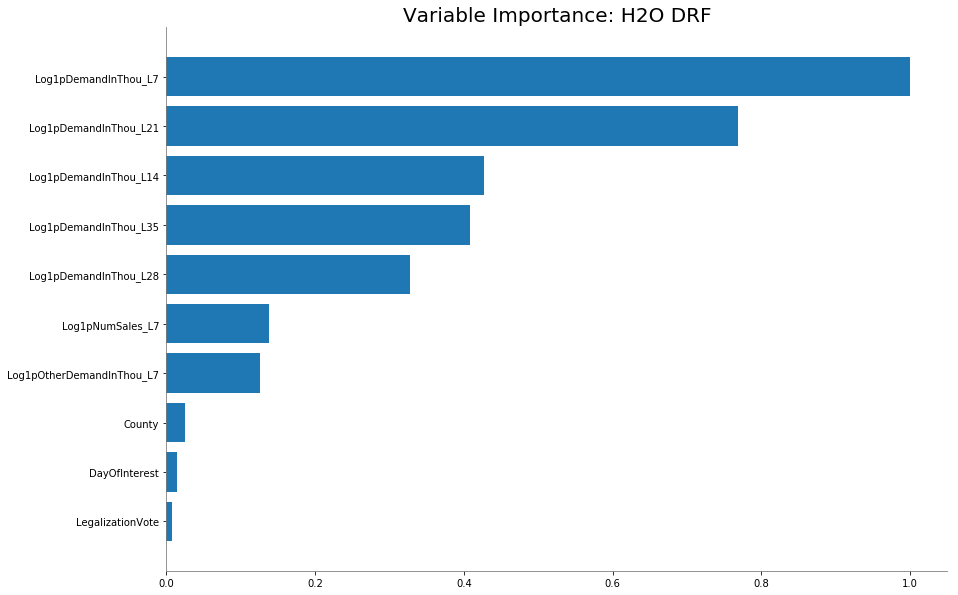

In [47]:
best_model.varimp_plot()

#### Examining demand lags

The variable importance plot of the leading model as well as the partial dependency plots show that five week's worth of sales should be sufficient for forecasting cannabis sales.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


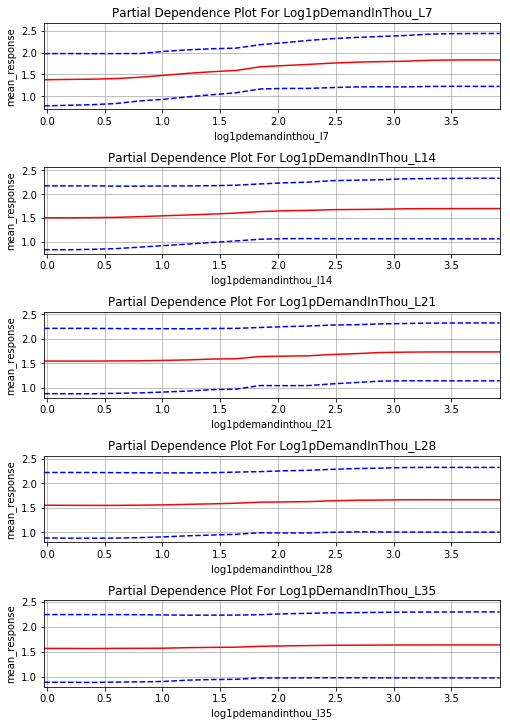

In [48]:
pdp_demand = best_model.partial_plot(data = train_hf,
                                     cols = ['Log1pDemandInThou_L7', 'Log1pDemandInThou_L14',
                                             'Log1pDemandInThou_L21', 'Log1pDemandInThou_L28',
                                             'Log1pDemandInThou_L35'])

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


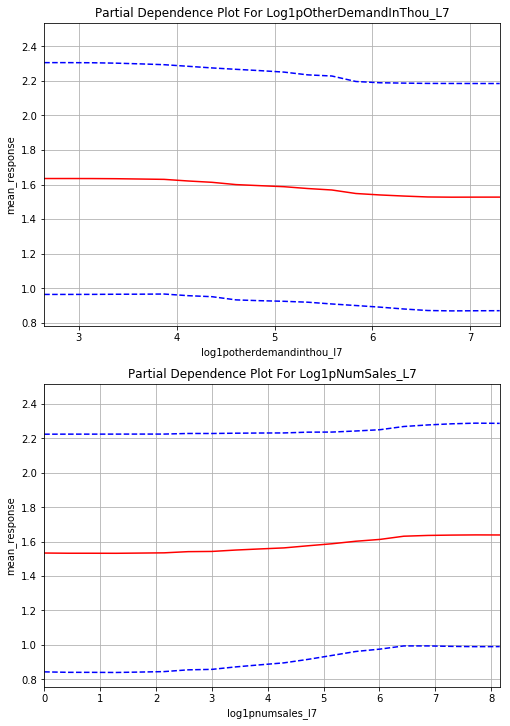

In [49]:
pdp_other_lagged = best_model.partial_plot(data = train_hf,
                                           cols = ['Log1pOtherDemandInThou_L7', 'Log1pNumSales_L7'])

In [50]:
glm = h2o.get_model(aml.leaderboard[7, 'model_id'])

In [51]:
print("R^2: train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(glm.r2(train = True), glm.r2(valid = True), glm.r2(xval = True)))

R^2: train = 0.9214, valid = 0.9264, xval = 0.9209


In [52]:
for j in ['Log1pDemandInThou_L7', 'Log1pDemandInThou_L14', 'Log1pDemandInThou_L21', 'Log1pDemandInThou_L28',
          'Log1pDemandInThou_L35']:
    print(j + ": {:.4f}".format(glm.coef()[j]))

Log1pDemandInThou_L7: 0.5418
Log1pDemandInThou_L14: 0.2107
Log1pDemandInThou_L21: 0.0666
Log1pDemandInThou_L28: 0.0566
Log1pDemandInThou_L35: 0.0217


#### Effects of unusual days

As the time series plot suggested, the effects of unusual days, such as 420 and Christmas, are factor into the trained model.

In [53]:
pdp_doi = best_model.partial_plot(data = train_hf, cols = ['DayOfInterest'], plot = False)[0].as_data_frame()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


In [54]:
pdp_doi.sort_values('mean_response', ascending = False)

,dayofinterest,mean_response,stddev_response,std_error_mean_response
4,FourTwenty,1.671158,0.709334,0.002422
1,ChristmasMinusOne,1.642617,0.710394,0.002425
10,ThanksgivingMinusOne,1.638590,0.712813,0.002434
9,PreJuly4th,1.628304,0.715839,0.002444
2,ChristmasMinusTwo,1.600179,0.703979,0.002403
6,N/A,1.583246,0.688998,0.002352
5,FourTwentySeven,1.549095,0.705651,0.002409
7,NewYearsDay,1.548752,0.695942,0.002376
11,ThanksgivingPlusSix,1.546976,0.701255,0.002394
8,NewYearsDayPlusSix,1.533595,0.693069,0.002366


#### Effect of legalization vote

Not too surprisingly, stores in different counties tend to behave similarly despite the differences in their voters' desire to legalize cannabis.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


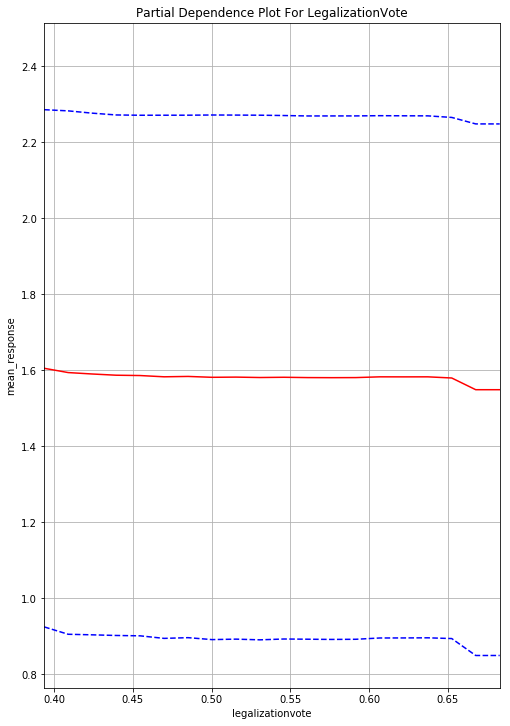

In [55]:
pdp_legalization = best_model.partial_plot(data = train_hf, cols = ['LegalizationVote'])

In [56]:
pdp_cats = best_model.partial_plot(data = train_hf, cols = ['County', 'City'], plot = False)
pdp_county = pdp_cats[0].as_data_frame()
pdp_city = pdp_cats[1].as_data_frame()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


In [57]:
pdp_county.sort_values('mean_response', ascending = False)

,county,mean_response,stddev_response,std_error_mean_response
6,SPOKANE,1.596291,0.675511,0.002306
4,PIERCE,1.594987,0.678453,0.002316
1,KING,1.589492,0.684486,0.002337
5,SNOHOMISH,1.587058,0.676214,0.002309
0,CLARK,1.584325,0.679491,0.002320
2,KITSAP,1.576821,0.676896,0.002311
3,OTHER,1.573325,0.689574,0.002354
8,WHATCOM,1.572167,0.678244,0.002316
7,THURSTON,1.569665,0.676533,0.002310


In [58]:
pdp_city.sort_values('mean_response', ascending = False)

,city,mean_response,stddev_response,std_error_mean_response
3,TACOMA,1.587973,0.685097,0.002339
0,OTHER,1.583931,0.689388,0.002354
2,SPOKANE,1.582883,0.686807,0.002345
1,SEATTLE,1.581167,0.688820,0.002352


## Shutdown Sparkling Water Services

The last step in this script is to be a good cloud citizen and shut down the H2O cluster.

In [ ]:
h2o.cluster().shutdown()